In [ ]:
!pip install -Uqq fastai

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [ ]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [ ]:
(path/'valid').ls()

(#2) [Path('valid/3'),Path('valid/7')]

In [ ]:
threes = (path/'train'/'3').ls()
sevens = (path/'train'/'7').ls()

In [ ]:
im3_path = threes[0]
im3 = Image.open(im3_path)
array(im3)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 128, 255, 255, 255,
        255, 255, 255, 255, 191,  64,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  64, 191, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 191,  64,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 128, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 128,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 128, 255, 255, 255, 255, 128, 128,
        128,   0,  64, 255, 255, 255, 128,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 128, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 128, 255, 255, 255, 191,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         64, 255, 255, 255, 255, 255,  64,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 128, 255,
        255, 255, 255, 255, 255, 128,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 128, 255, 255,
        255, 255, 255, 255, 255,  64,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  64, 255, 255,
        255, 255, 255, 255, 255, 255,  64,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 128,
        128, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 191, 255, 255, 255, 255, 191,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  64, 255, 255, 255, 255,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255, 255, 255, 255, 128,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255, 255, 255, 255, 128,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  64,  64,   0,   0,   0,   0,
          0,   0,   0, 191, 255, 255, 255, 255,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 128, 255, 255, 255, 191, 128,   0,
        128, 191, 255, 255, 255, 255, 255, 191,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 128, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 128, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 191,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   

**Baseline: Pixel Similarity**

In [ ]:
#A Tensor is a N-dimensional Matrix: A Scalar is a 0-dimensional tensor. A Vector is a 1-dimensional tensor. A Matrix is a 2-dimensional tensor.

im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,128,255,255,255,255,255,255,255,191,64,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,64,191,255,255,255,255,255,255,255,255,255,255,191,64,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,128,255,255,255,255,255,255,255,255,255,255,255,255,128,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,128,255,255,255,255,128,128,128,0,64,255,255,255,128,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,255,255,255,255,0,0,0,0,0,0,0,0


In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

In [ ]:
len(seven_tensors), len(three_tensors)

(6265, 6131)

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape # shape is the size of each axis of a tensor.

torch.Size([6131, 28, 28])

In [ ]:
len(stacked_threes.shape) # the length of a tensor's shape is its rank

3

In [ ]:
stacked_threes.ndim # the number of tensor's dimensions

3

<Axes: >

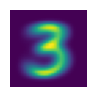

In [ ]:
# for every pixel position, this will compute the average of that pixel over all images
mean3 = stacked_threes.mean(0) # "ideal" 3
show_image(mean3)

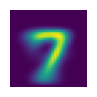

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);


<Axes: >

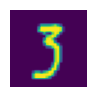

In [ ]:
a3 = stacked_threes[69]
show_image(a3)

In [ ]:
# 2 loss functions which calculate distance of a3 from mean3
dist3_mse = ((a3 - mean3)**2).mean().sqrt()
dist3_mae = ((a3 - mean3)).abs().mean()
dist3_mae, dist3_mse

(tensor(0.1122), tensor(0.1993))

In [ ]:
dist7_mse = ((a3 - mean7)**2).mean().sqrt()
dist7_mae = (a3 - mean7).abs().mean()
dist7_mae, dist7_mse

(tensor(0.1255), tensor(0.2471))

In [ ]:
#mean square error and mean absolute error are implemented in torch.nn.functional
import torch.nn.functional as F

In [ ]:
F.l1_loss(a3.float(), mean7), F.mse_loss(a3, mean7).sqrt()

(tensor(0.1255), tensor(0.2471))

Metrics and Broadcasting

In [ ]:
#valid_stacked_threes_tensor = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255

valid_threes = (path/'valid'/'3').ls()
valid_sevens = (path/'valid'/'7').ls()

valid_threes, valid_sevens

((#1010) [Path('valid/3/686.png'),Path('valid/3/9409.png'),Path('valid/3/6285.png'),Path('valid/3/2348.png'),Path('valid/3/6289.png'),Path('valid/3/9275.png'),Path('valid/3/1513.png'),Path('valid/3/8080.png'),Path('valid/3/4162.png'),Path('valid/3/883.png')...],
 (#1028) [Path('valid/7/1721.png'),Path('valid/7/1122.png'),Path('valid/7/254.png'),Path('valid/7/4568.png'),Path('valid/7/5714.png'),Path('valid/7/8401.png'),Path('valid/7/2480.png'),Path('valid/7/9024.png'),Path('valid/7/7801.png'),Path('valid/7/4868.png')...])

In [ ]:
valid_threes_tensor = [tensor(Image.open(o)) for o in valid_threes]
valid_sevens_tensor = [tensor(Image.open(o)) for o in valid_sevens]

stacked_valid_threes_tensor = torch.stack(valid_threes_tensor).float()/255
stacked_valid_sevens_tensor = torch.stack(valid_sevens_tensor).float()/255

stacked_valid_threes_tensor.shape, stacked_valid_sevens_tensor.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

torch.Size([28, 28])

In [ ]:
def mnist_distance(a, b):
  return (a-b).abs().mean((-1, -2))
  # return F.l1_loss(a, b, reduction='none').mean([-1,-2])

mnist_distance(a3, mean3)

tensor(0.1122)

our stacked_valid_threes_tensor is of dimension 3 whereas mean3(the ideal 3) is just 1 dimension.

**Using a loop** to calculate mnist_distance between each image in stacked_valid_threes_tensor with mean3 is **SLOW**

we pass stacked_valid_threes_tensor in mnist_distance.

PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use **broadcasting**.

*   PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory

*   It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).



In [ ]:
mnist_distance(stacked_valid_threes_tensor, mean3)

tensor([0.1092, 0.1493, 0.1408,  ..., 0.1299, 0.1304, 0.1478])

Now to predict whether the image is a 3 or 7,


*   if distance of image from mean3 < distance from mean7 => image is a 3


*   if distance of image from mean3 > distance from mean7 => image is NOT a 3



In [ ]:
def is_3(x):
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

is_3(a3), is_3(tensor(Image.open((path/'valid'/'7').ls()[2]))) #random 7 from validation set

(tensor(True), tensor(False))

In [ ]:
accuracy3 = is_3(stacked_valid_threes_tensor).float().mean()
accuracy7 = 1-is_3(stacked_valid_sevens_tensor).float().mean()

(accuracy3+accuracy7)/2

tensor(0.9511)

**Stochastic Gradient Descent**